<center><img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Logo_PolSl.svg" width="240" height="240"/></center>

Statystyczna Analiza Danych  
Projekt zaliczeniowy  
Autor: Kacper Moll

# Spis Treści:
1. Baza danych
    1. utworzenie zbioru danych (import, łączenie arkuszy)
    2. podstawowe statystyki danych
    3. analiza przypadków odstających, wpływ eliminacji przypadków odstających na podstawowe statystyki
    4. wykres ramka-wąsy
2. Testy parametryczne i nieparametryczne
    1. test istotności różnic między grupami (założenia)
    2. test istotności różnic między zmiennymi
    3. testy normalności rozkładu
    4. przedział ufności dla średniej
3. Korelacja i regresja
    1. wyznaczanie i analiza współczynników korelacji Pearsona i Spearmana i test istotności tych współczynników
    2. regresja liniowa, budowa i weryfikacja
4. Analiza szeregów czasowych
    1. Przygotowanie danych
    1. trend szeregu czasowego
    2. autokorelacja szeregu
    3. analiza Fouriera szeregu czasowego - Periodogram
    4. współczynniki sezonowości 

<h1> I. Baza danych

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import seasonal
from mlinsights.mlmodel import IntervalRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [219]:
def check_null_hypothesis(p):
    return f"Odrzucamy zerową hipotezę ponieważ (p=={p}) < 0.05" if p < 0.05 else f"Przyjmujemy zerową hipotezę ponieważ (p=={p}) > 0.05"

In [220]:
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25]))

In [221]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

In [222]:
DOLNY_KWARTYL = 0.25
GORNY_KWARTYL = 0.75
COLORS = ["blue", "orange", "green", "red", "blue", "orange", "green", "red"]
FILES_PATH = 'Import_danych/Wybrane_miasta/'

<h2> 1. utworzenie zbioru danych (import, łączenie arkuszy)

In [223]:
df_cz = pd.read_excel(f'{FILES_PATH}Częstochowa Baczyńskiego 24h 2007-2014.xlsx', decimal=',')
df_zb = pd.read_excel(f'{FILES_PATH}Zabrze 24h 2007-2014.xlsx', decimal=',')

In [224]:
df_cz.set_index('Data', inplace=True)
df_zb.set_index('Data', inplace=True)

In [225]:
df = df_zb.join(df_cz).astype('float')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df.interpolate("time")

<h5>Stworzenie histogramu dla każdej zmiennej, do dalszych analiz wezmę te zmienne, którym jest najbliżej do rozkładu normalnego.

array([[<AxesSubplot: title={'center': 'ZB_As(PM10)_24g'}>,
        <AxesSubplot: title={'center': 'ZB_BaP(PM10)_24g'}>,
        <AxesSubplot: title={'center': 'ZB_Cd(PM10)_24g'}>,
        <AxesSubplot: title={'center': 'ZB_Ni(PM10)_24g'}>,
        <AxesSubplot: title={'center': 'ZB_Pb(PM10)_24g'}>,
        <AxesSubplot: title={'center': 'ZB_PM10_24g'}>],
       [<AxesSubplot: title={'center': 'ZB_CO_1g'}>,
        <AxesSubplot: title={'center': 'ZB_NO_1g'}>,
        <AxesSubplot: title={'center': 'ZB_NO2_1g'}>,
        <AxesSubplot: title={'center': 'ZB_NOx_1g'}>,
        <AxesSubplot: title={'center': 'ZB_O3_1g'}>,
        <AxesSubplot: title={'center': 'ZB_SO2_1g'}>],
       [<AxesSubplot: title={'center': 'ZB_cisnienie_1g'}>,
        <AxesSubplot: title={'center': 'ZB_kier_1g'}>,
        <AxesSubplot: title={'center': 'ZB_predk_1g'}>,
        <AxesSubplot: title={'center': 'ZB_prom_1g'}>,
        <AxesSubplot: title={'center': 'ZB_temp_1g'}>,
        <AxesSubplot: title={'center': 

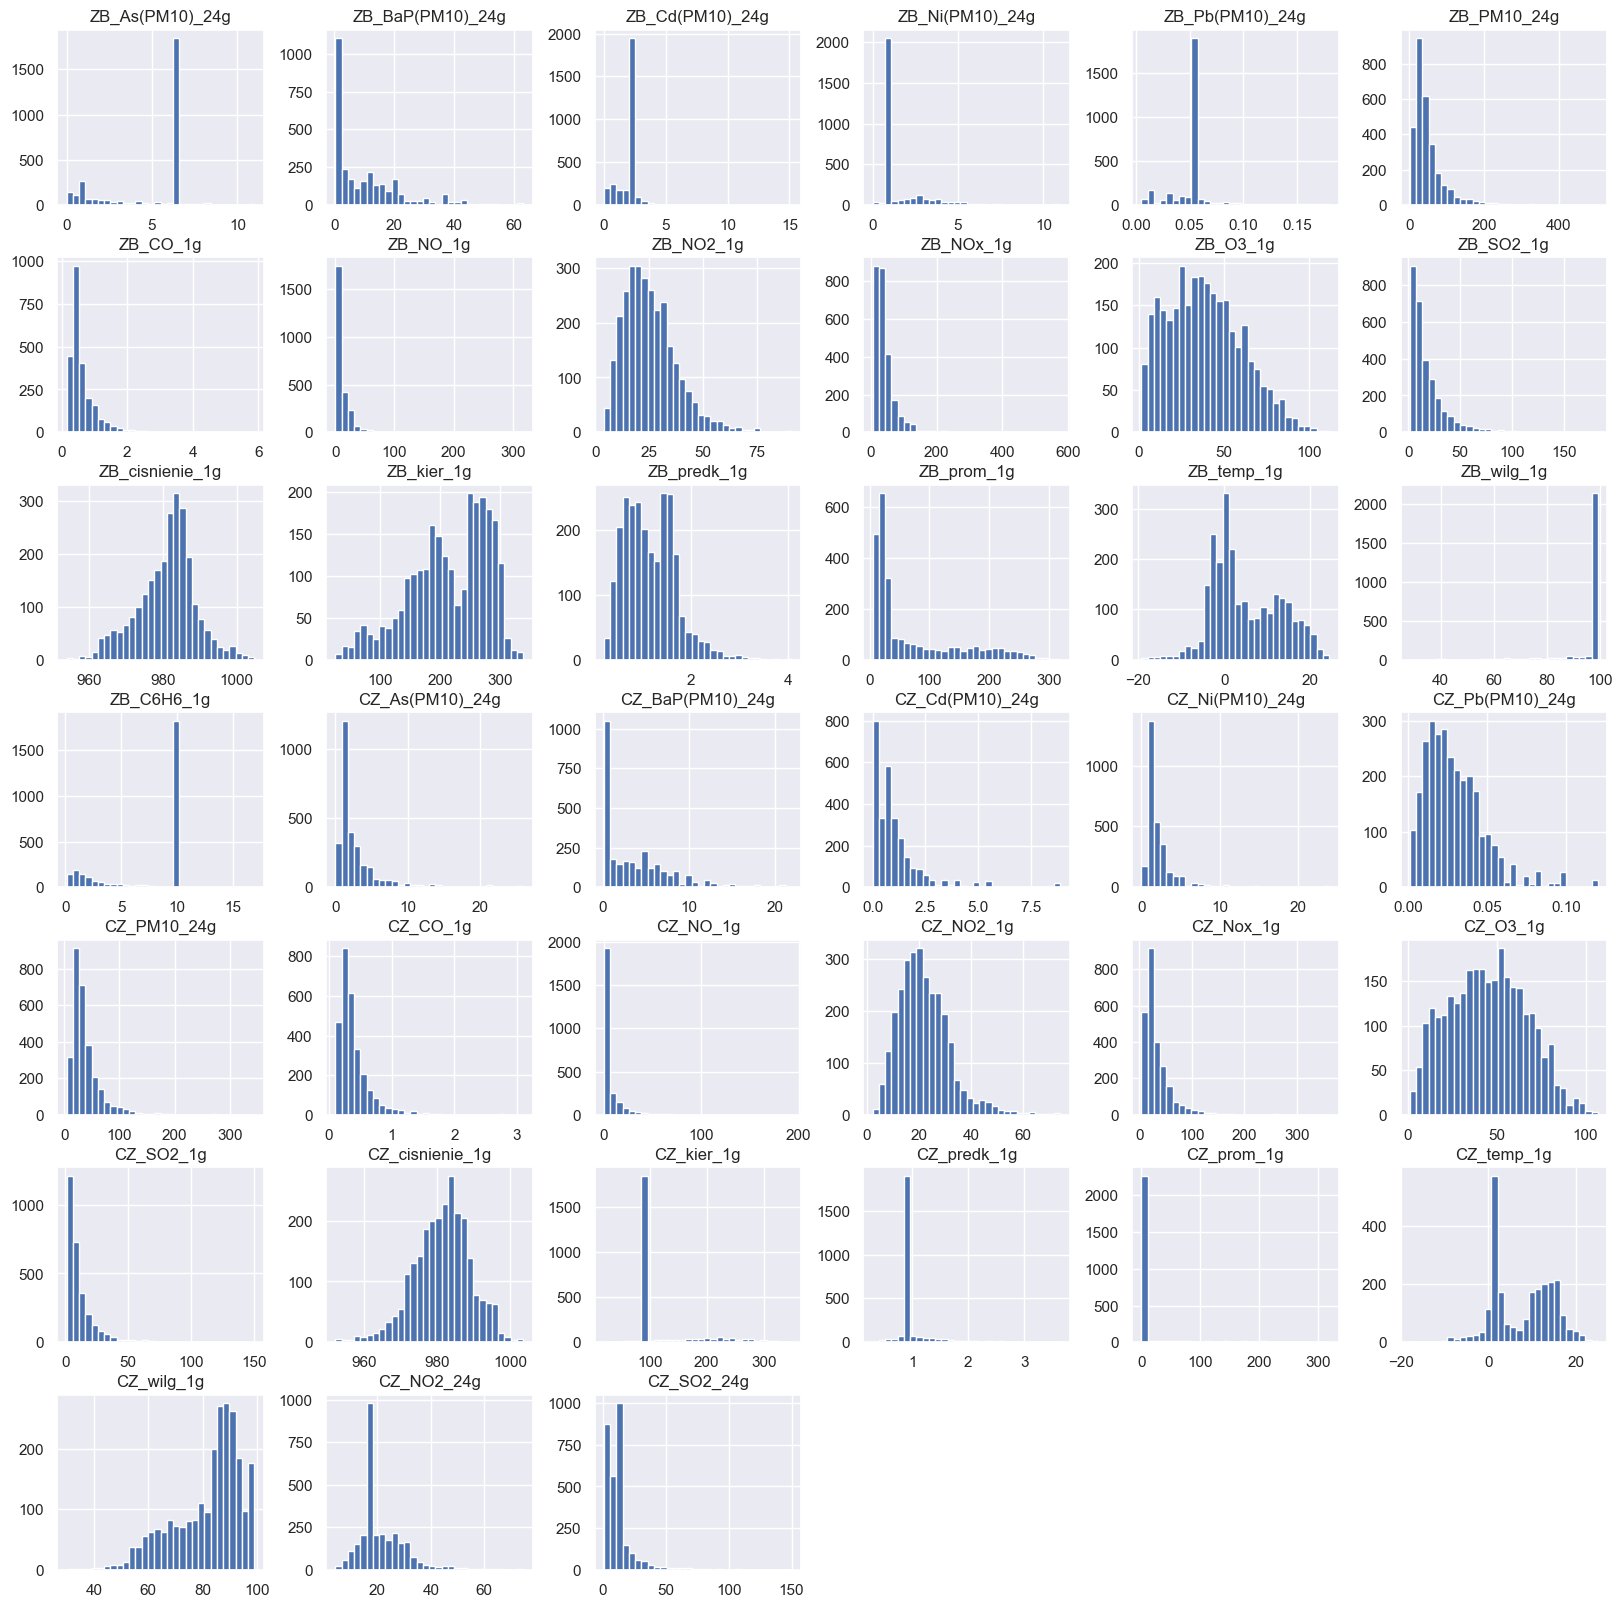

In [226]:
df.hist(bins=30, figsize=(20, 20))

In [227]:
COLUMNS_TO_ANALYZE = ['ZB_NO2_1g','CZ_NO2_1g']

In [228]:
df_final = df[COLUMNS_TO_ANALYZE].copy()

<h5>Wybrane dane do przyszłej analizy:

In [229]:
df_final.head()

,ZB_NO2_1g,CZ_NO2_1g
Data,,
2007-01-01,NaN,11.347826
2007-01-02,NaN,16.956522
2007-01-03,NaN,15.652174
2007-01-04,25.956522,21.086957
2007-01-05,17.956522,16.304348


<h2> 2. podstawowe statystyki danych

<h5>Podstawowe statystyki przed wyczyszczeniem przypadków odstających

Podstawowe statystyki opisowe dla wybranych zmiennych:  
- N ważnych,
- średnia,
- odchylenie standardowe,
- minimum,
- pierwszy kwartyl,
- drugi kwartyl = mediana,
- trzeci kwartyl,
- maximum.

In [230]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
ZB_NO2_1g,2917.0,25.491757,12.288046,4.043478,16.391304,23.608696,32.052174,91.047619
CZ_NO2_1g,2920.0,21.983612,9.874159,2.130435,15.134881,20.521739,27.375079,74.608696


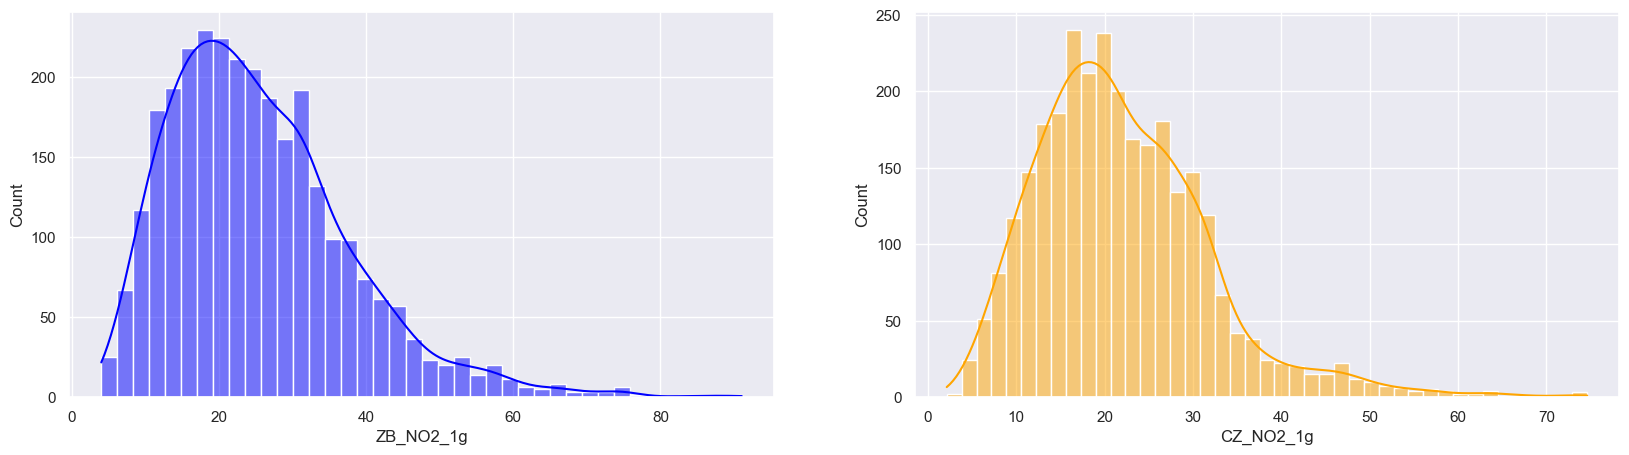

In [231]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.histplot(df_final[COLUMNS_TO_ANALYZE[i]], kde=True, ax=axs[i], color=COLORS[i])
plt.show()

Histogramy jasno wskazują, że rozkład NO2 dla obu miast nie jest rozkładem normalnym.

Test Shapiro-Wilka:  
- H0: próbka NO2 należy do rozkładu normalnego
- H1: próbka NO2 nie należy do rozkładu normalnego

In [232]:
for col in df_final.columns:
    print(f"Dla {col}: ", end="")
    print(check_null_hypothesis(stats.shapiro(df_final[col].dropna()).pvalue))

Dla ZB_NO2_1g: Odrzucamy zerową hipotezę ponieważ (p==1.5177157273035924e-32) < 0.05
Dla CZ_NO2_1g: Odrzucamy zerową hipotezę ponieważ (p==2.0781927562068037e-32) < 0.05


Dla obu miast wartość p uzyskana z testu Shapiro-Wilka jest poniżej 0.05, z tego powodu odrzucamy hipotezę zerową. Przyjmuję H1 świadczące, że rozkład próbek NO2 nie jest rozkładem normalnym.

**Analiza histogramów oraz wyników testów Shapiro-Wilka wskazuje, że do wykonania wykresów ramka-wąsy należy użyć mediany.**

<h2> 3. analiza przypadków odstających, wpływ eliminacji przypadków odstających na podstawowe statystyki

Analiza przypadków odstających na podstawie wizualizacji

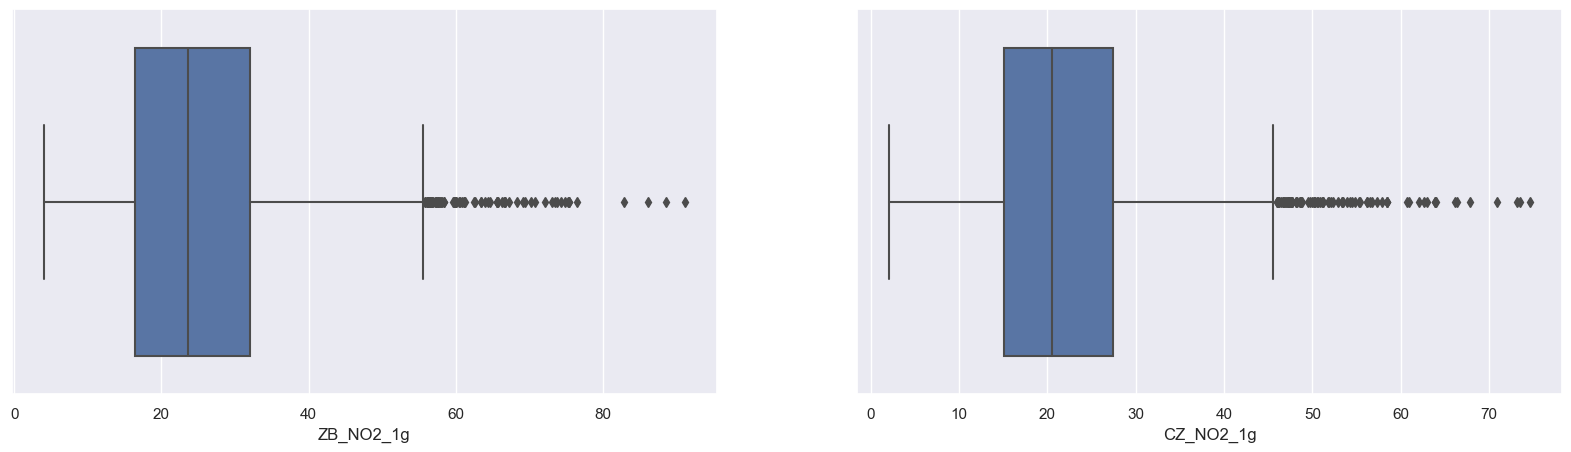

In [233]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.boxplot(x=df_final[COLUMNS_TO_ANALYZE[i]], ax=axs[i])
plt.show()

<H5> Z powyższego wykresu można łatwo zauważyć, że obie kolumny mają wiele obserwacji odstających. Ponieważ mediana jest bliżej dolnej krawędzi ramki, a górne wąsy są dłuższe niż dolne można wywnioskować, że dane posiadają lekką prawostronną asymetrię (dodatnia skośność).

<h5> Zastosowanie metody IQR - interquartile range (rozstęp kwartylny/ćwiartkowy). IQR - miara, która sporo mówi o populacji, gdyż w tych granicach mieści się 50% (czyli dokładnie połowa) badanych obiektów. Im większy rozstęp kwartylny, tym bardziej zróżnicowana jest cecha statystyczna.`

In [234]:
Q1, Q3, IQR = [], [], []
whisker_width = 1.5
for i, v in enumerate(df_final.columns):
    Q1.append(df_final[v].quantile(0.25))
    Q3.append(df_final[v].quantile(0.75))
    IQR.append(Q3[i] - Q1[i])

In [235]:
outliers_0 = df_final[(df_final[df_final.columns[0]] < Q1[0] - whisker_width*IQR[0]) | (df_final[df_final.columns[0]] > Q3[0] + whisker_width*IQR[0])]
outliers_0.head()

,ZB_NO2_1g,CZ_NO2_1g
Data,,
2007-03-13,65.565217,56.217391
2007-11-20,56.045455,56.217391
2007-11-23,56.478261,63.869565
2008-12-30,56.454545,24.158616
2008-12-31,55.826087,24.134964


In [236]:
outliers_1 = df_final[(df_final[df_final.columns[1]] < Q1[1] - whisker_width*IQR[1]) | (df_final[df_final.columns[1]] > Q3[1] + whisker_width*IQR[1])]
outliers_1.head()

,ZB_NO2_1g,CZ_NO2_1g
Data,,
2007-03-13,65.565217,56.217391
2007-03-30,51.956522,47.043478
2007-04-03,44.652174,48.739130
2007-04-17,38.652174,54.260870
2007-04-23,26.801242,47.090909


In [237]:
for i, v in enumerate(df_final.columns):
    df_final.loc[df_final[v] < Q1[i] - 1.5*IQR[i], v] = Q1[i] - 1.5*IQR[i]
    df_final.loc[df_final[v] > Q3[i] + 1.5*IQR[i], v] = Q3[i] + 1.5*IQR[i]

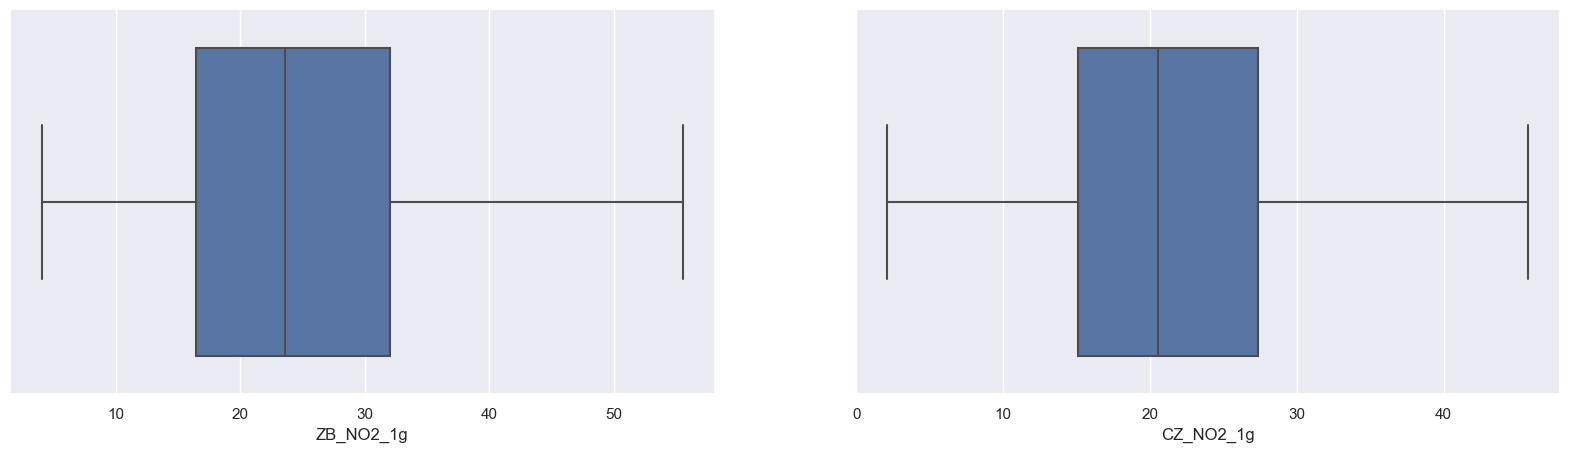

In [238]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.boxplot(x=df_final[COLUMNS_TO_ANALYZE[i]], ax=axs[i])
plt.show()

Test Shapiro-Wilka po zastąpieniu przypadków odstających:  
- H0: próbka NO2 należy do rozkładu normalnego
- H1: próbka NO2 nie należy do rozkładu normalnego

In [239]:
for col in df_final.columns:
    print(f"Dla {col}: ", end="")
    print(check_null_hypothesis(stats.shapiro(df[col].dropna()).pvalue))

Dla ZB_NO2_1g: Odrzucamy zerową hipotezę ponieważ (p==1.5177157273035924e-32) < 0.05
Dla CZ_NO2_1g: Odrzucamy zerową hipotezę ponieważ (p==2.0781927562068037e-32) < 0.05


<h5> Powyższe wykresy pokazują, że nie ma już przypadków odstających. Przypadki odstające zostały zastąpione przez 1,5*Górny Kwartyl oraz 1,5*razy dolny kwartyl, czyli +/- 2,7*odchylenie standardowe.

<h5> Normalizacja danych. Dwie transformacje zostały sprawdzone: transformacja logarytmiczna oraz transformacja pierwiastkowa.

In [240]:
df_sqrt = np.sqrt(df_final)
df_log = np.log(df_final)

<h5> Trnsformacja pierwiastkowa

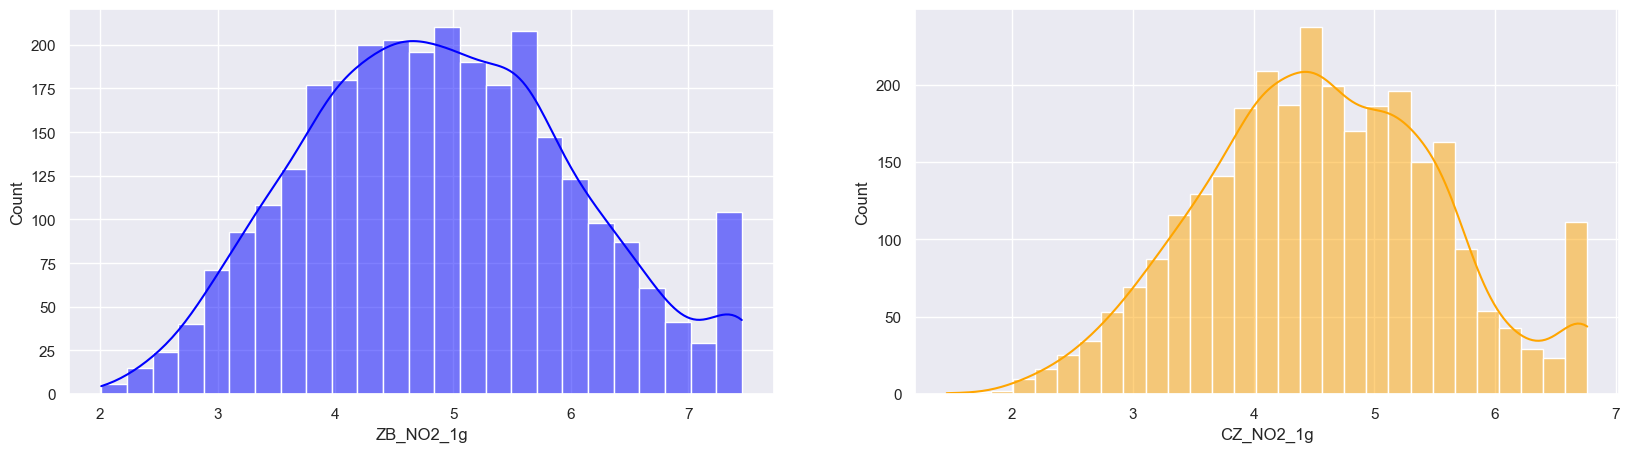

In [241]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.histplot(df_sqrt[COLUMNS_TO_ANALYZE[i]], kde=True, ax=axs[i], color=COLORS[i])
plt.show()

<h5> Transformacja logarytmiczna

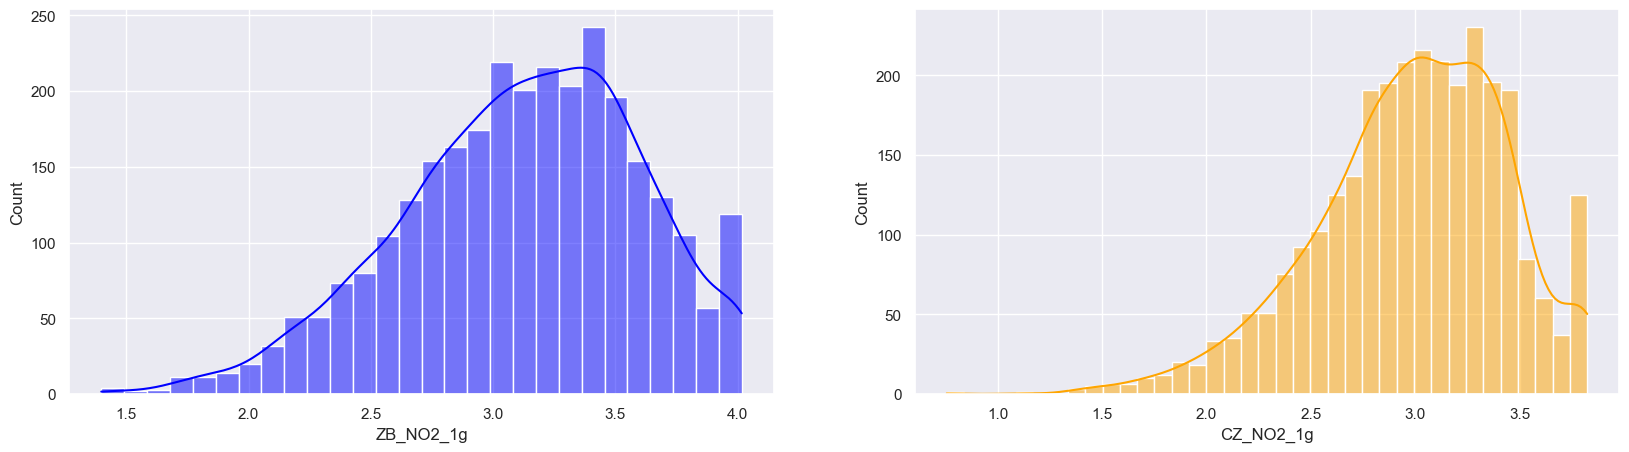

In [242]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.histplot(df_log[COLUMNS_TO_ANALYZE[i]], kde=True, ax=axs[i], color=COLORS[i])
plt.show()

Wybieram tranformację pierwiastkową. Transformacja logarytmiczna bardzo dobrze się sprawdza w przypadku, rozkład ma nasiloną skośność. W przypadku analizowanych dnaych skośność, nie była nasilona, dlatego transformacja pierwiastkowa sprawdza się znacznie lepiej. Jak widać na powyższych histogramach.

In [243]:
df_final = df_sqrt.copy()

<h2> 4. wykresy ramka – wąsy

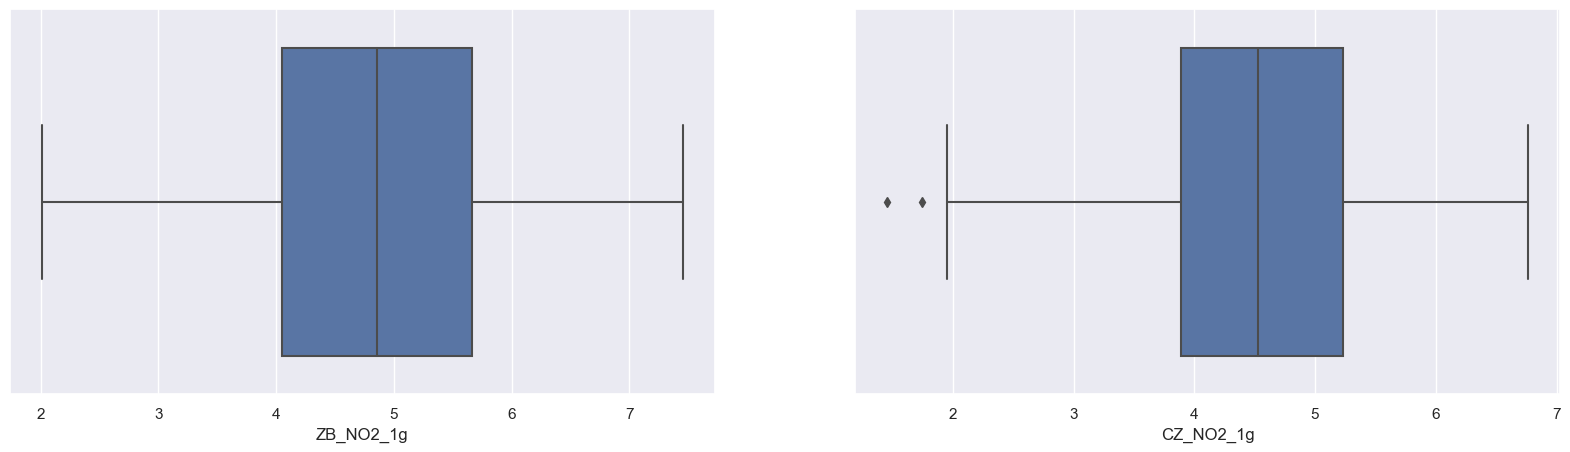

In [244]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.boxplot(x=df_final[COLUMNS_TO_ANALYZE[i]], ax=axs[i])
plt.show()

Podstawowe statystyki danych po normalizacji oraz zastąpieniu przypadków odstających

In [245]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
ZB_NO2_1g,2917.0,4.894059,1.149219,2.010840,4.048618,4.858878,5.661464,7.452750
CZ_NO2_1g,2920.0,4.559604,0.988079,1.459601,3.890357,4.530093,5.232120,6.762793


In [246]:
for col in df_final.columns:
    print(f"Dla {col}: ", end="")
    print(check_null_hypothesis(stats.shapiro(df_final[col].dropna()).pvalue))

Dla ZB_NO2_1g: Odrzucamy zerową hipotezę ponieważ (p==7.295145932652292e-13) < 0.05
Dla CZ_NO2_1g: Odrzucamy zerową hipotezę ponieważ (p==7.435909110675709e-10) < 0.05


<h1> II. Testy parametryczne i nieparametryczne

Paramteryczne:

W celu wykonania tej analizy stworzyłem nową zmienną - 'Season'. Kolumna ta informuje nas podczas której pory roku został wykonany odzczyt. 
- 1: zima
- 2: wiosna
- 3: lato
- 4: jesien

In [247]:
df_final["Season"] = df_final.index.map(lambda x: (x.month-1) %12 // 3 + 1)
season_to_str = {
    1: "Zima",
    2: "Wiosna",
    3: "Lato",
    4: "Jesien"
}

#### 2. test istotności różnic między zmiennymi

Test t studenta dla prób niezależnych

- H0: Średnie stężenie związku NO2 w obu miastach jest równe.
- H1: Średnie stężenia związku NO2 różnią się.

In [248]:
for i, v in enumerate(COLUMNS_TO_ANALYZE):
    for j, v2 in enumerate(COLUMNS_TO_ANALYZE):
        if i >= j:
            continue
        print(f"dla {v} i {v2}")
        print(check_null_hypothesis(stats.ttest_rel(df_final[v], df_final[v2], nan_policy="omit").pvalue))

dla ZB_NO2_1g i CZ_NO2_1g
Odrzucamy zerową hipotezę ponieważ (p==4.220789802874582e-71) < 0.05


Według testu prób niezależnych odrzucam hipotezę H0, ponieważ wartość p < 0,05. Przyjmuję Hipotezę H1. Oznacza to, że średnie stężenia związku NO2 dla wybranych miast statyczynie sie różnią.

#### 1. test istotności różnic między grupami (założenia)

Wykonuję analizę dla zmiennej niezależnej NO2 w obu miastach, oraz dla zmiennej grupującej: Season - dla zimy i lata.  

Stawiam Hipotezę:  
H0: Stężenie związku NO2 w obu miastach względem zmiennych grupujących Lata i Zimy jest takie samo.  
H1: Stężenia związku NO2 różnią się.  

Według testu prób niezależnych odrzucam hipotezę H0, ponieważ wartość p < 0,05. Przyjmujemy Hipotezę H1. Oznacza to, że średnie stężenia związku NO2 dla wybranych miast w okresie lata i zimy są statystycznie różne.

In [249]:
for x in COLUMNS_TO_ANALYZE:
    for i in range(1,5):
        for j in range(i+1,5):
            if f"{season_to_str[i]} i {season_to_str[j]}" == 'Zima i Lato':
                print(f"{x} {season_to_str[i]} i {season_to_str[j]}")
                print(check_null_hypothesis(stats.ttest_rel(df_final[x][df_final["Season"]==i][:722], df_final[x][df_final["Season"]==j][:722], nan_policy="omit").pvalue))

ZB_NO2_1g Zima i Lato
Odrzucamy zerową hipotezę ponieważ (p==3.905318536491716e-55) < 0.05
CZ_NO2_1g Zima i Lato
Odrzucamy zerową hipotezę ponieważ (p==2.455501046357068e-57) < 0.05


In [250]:
df_final = df_final.drop("Season", axis=1)

Nieparametryczne

Przykładem testu nieparametrycznego jest już wcześniej wykonywany test Shapiro-Wilka. 

<h2> 4. testy normalności rozkładu

Zrobiony wyżej w punkcie z histogramami, opisane jest tam, że wartość p < 0.05 dla
testu Shapiro-Wilka co świadczy o tym, że nasze danie nie posiadają rozkładu
normalnego.

<h2> 5. przedział ufności dla średniej

Przedział ufności dla średniej pozwala oszacować prawdopodobny przedział, w którym znajduje się średnia danego rozkładu normalnego.  
Oznacza to, że jeżeli posiadam tylko próbkę z danych za pomocą przedziału ufności dla średniej jesteśmy w stanie oszacować w jakim przedziale będzie się znajdować średnia
wartość dla całej próby.  
Szerokość przedziału ufności średniej zależy od: wybranego %, liczebności próby oraz od odchylenia standardowego.  
Im mniejsze jest odchylenie standardowe tym przedział ufności jest mniejszy.  

Przedziały ufności dla średniej z 95% dla NO2 w obu miastach

In [251]:
for col in df_final.columns:
   stats_df = stats.t.interval(0.95, len(df_final), loc=df_final[col].mean(), scale=df_final[col].std())
   print(f"Przedział ufności średniej dla {col}: {stats_df}")

Przedział ufności średniej dla ZB_NO2_1g: (2.640696819221483, 7.147421677877483)
Przedział ufności średniej dla CZ_NO2_1g: (2.622201858415081, 6.49700537127936)


In [252]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
ZB_NO2_1g,2917.0,4.894059,1.149219,2.010840,4.048618,4.858878,5.661464,7.452750
CZ_NO2_1g,2920.0,4.559604,0.988079,1.459601,3.890357,4.530093,5.232120,6.762793


<h1> III. Korelacja i regresja

<h2> 1. wyznaczanie i analiza współczynników korelacji Pearsona i Spearmana oraz test istotności

Test istotności:  
H0: Dane nie są ze sobą skorelowane  
H1: Dane są ze sobą skorelowane  

Dla zmiennych ilościowych o rozkładzie normalnym należy wybrać współczynnik korelacji Pearsona. Jeśli dane nie mają rozkładu normalnego lub mają uporządkowane kategorie, to należy wybrać współczynniki Spearmana.

<h3> Korelacja Pearson'a

Współczynnik korelacji Pearsona jest miarą liniowej zależności między dwiema cechami. Jest to stosunek kowariancji x i y do iloczynu ich odchyleń standardowych.

In [270]:
c_df_final = df_final.dropna()
for i, v in enumerate(COLUMNS_TO_ANALYZE):
    for j, v2 in enumerate(COLUMNS_TO_ANALYZE):
        if i >= j:
            continue
        r_pearson, p_pearson = stats.pearsonr(c_df_final[v], c_df_final[v2])
        print(f"Korelacja pearsona między {v} a {v2}: {r_pearson}")
        print(check_null_hypothesis(p_pearson))

Korelacja pearsona między ZB_NO2_1g a CZ_NO2_1g: 0.5856986159665585
Odrzucamy zerową hipotezę ponieważ (p==2.896327919204275e-268) < 0.05


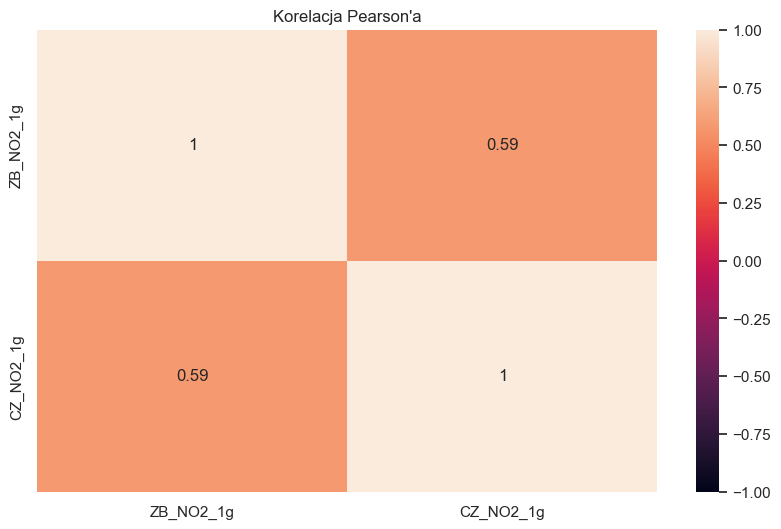

In [271]:
r = c_df_final.corr()
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_final.corr(), vmin=-1, 
                      vmax=1, annot=True)
plt.title("Korelacja Pearson'a")
plt.show()

<h3> Korelacja Spearman'a

Interpretacja jest podobna do klasycznego współczynnika korelacji Pearsona, z jednym zastrzeżeniem: w odróżnieniu od współczynnika Pearsona, który mierzy liniową zależność między zmiennymi, a wszelkie inne związki traktuje jak zaburzone zależności liniowe, korelacja rangowa pokazuje dowolną monotoniczną zależność (także nieliniową)

In [255]:
for i, v in enumerate(COLUMNS_TO_ANALYZE):
    for j, v2 in enumerate(COLUMNS_TO_ANALYZE):
        if i >= j:
            continue
        rho_spearman, p_spearman = stats.spearmanr(c_df_final[v], c_df_final[v2])
        print(f"Korelacja spearman między {v} a {v2}: {rho_spearman}")
        print(check_null_hypothesis(p_spearman))

Korelacja spearman między ZB_NO2_1g a CZ_NO2_1g: 0.5471349711353417
Odrzucamy zerową hipotezę ponieważ (p==1.7498510129663629e-227) < 0.05


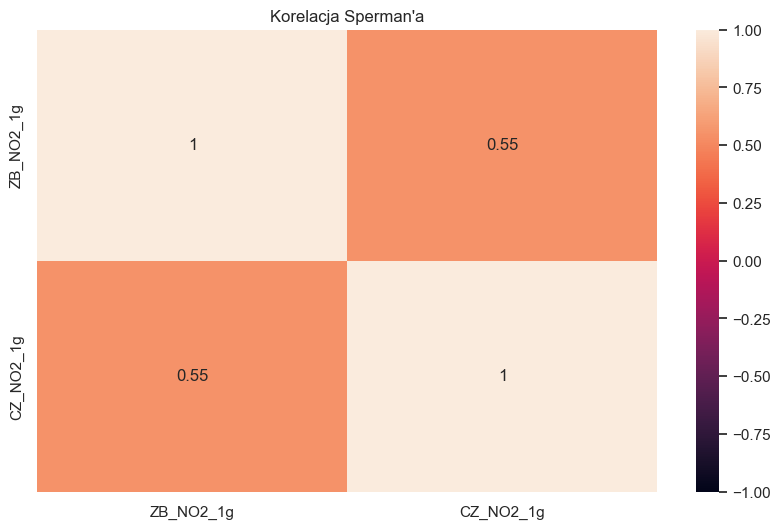

In [256]:
r = c_df_final.corr(method='spearman')
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_final.corr(method='spearman'), vmin=-1, 
                      vmax=1, annot=True)
plt.title("Korelacja Sperman'a")
plt.show()

#### 2. regresja liniowa, budowa i weryfikacja

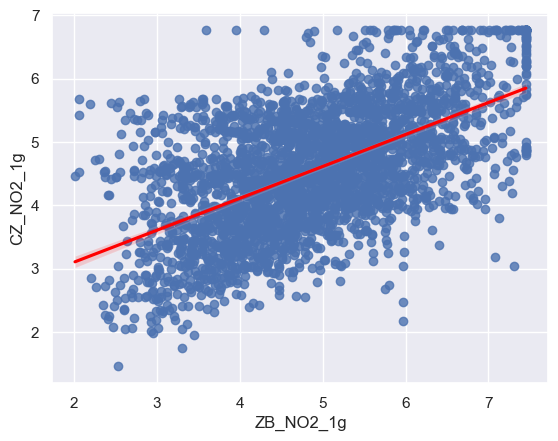

In [288]:
sns.regplot(df_final, x=df_final[df_final.columns[0]], y=df_final[df_final.columns[1]], line_kws={"color": "red"})
plt.show()

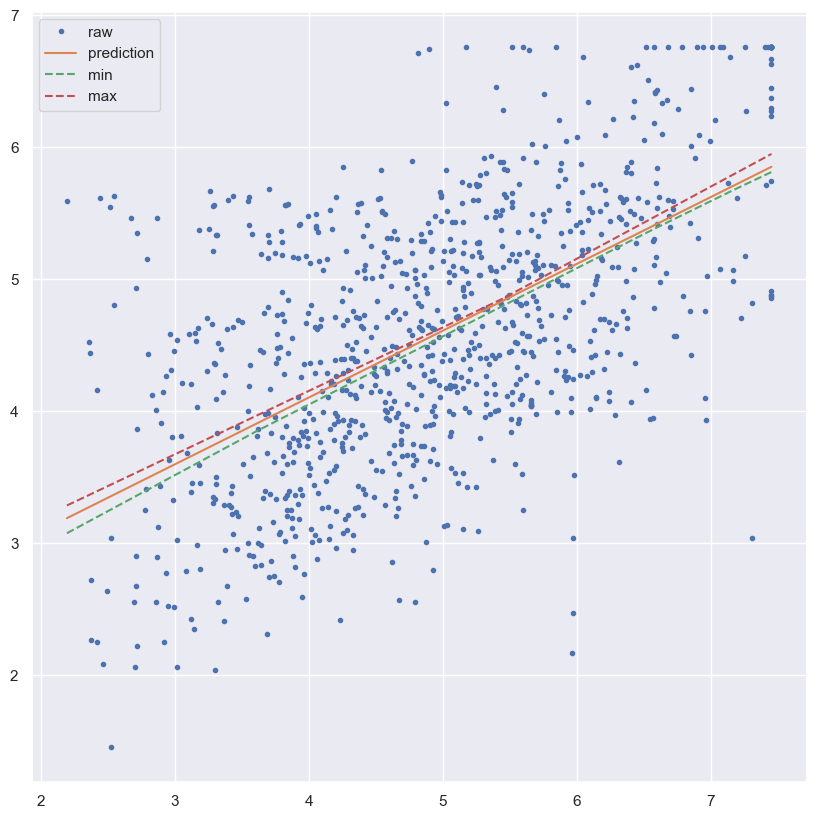

Współczynnik R^2: 0.32


In [292]:
X, y = c_df_final[c_df_final.columns[0]].values.reshape(-1,1), c_df_final[c_df_final.columns[1]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lin = IntervalRegressor(LinearRegression(), alpha=0.95)
lin.fit(X_train, y_train)
IntervalRegressor(estimator=LinearRegression())

sorted_X = np.array(list(sorted(X_test)))
pred = lin.predict(sorted_X)
bootstrapped_pred = lin.predict_sorted(sorted_X)
min_pred = bootstrapped_pred[:, 0]
max_pred = bootstrapped_pred[:, bootstrapped_pred.shape[1]-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(X_test, y_test, '.', label="raw")
ax.plot(sorted_X, pred, label="prediction")
ax.plot(sorted_X, min_pred, '--', label="min")
ax.plot(sorted_X, max_pred, '--', label="max")
ax.legend()
plt.show()
y_pred = lin.predict(X_test)
# The coefficient of determination: 1 is perfect prediction
print("Współczynnik R^2: %.2f" % r2_score(y_test, y_pred))

Współczynnik R2 mówi o tym, jak procent zmienności danych (czyli wariancji zmiennej objaśnianej) jest wyjaśniany w modelu.

Test ten służy do weryfikacji hipotezy o braku zależności liniowej pomiędzy badanymi cechami populacji i opiera się na współczynniku nachylenia prostej wyliczonym dla próby. Im wartość współczynnika będzie bliższa 0, tym słabszą zależność dopasowana prosta przedstawia.

# IV. Analiza szeregów czasowych

<h2> Zaczynam analizę szeregu czasowego przez pozbycie się szumu przy użyciu średniej ruchomej

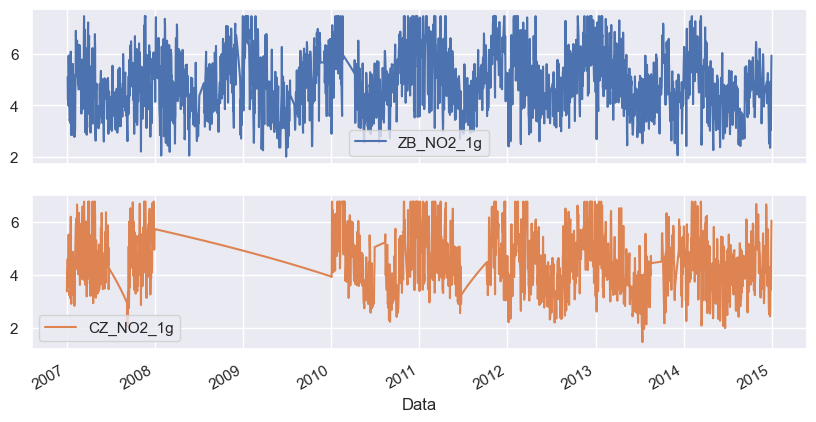

In [289]:
_ = df_final.plot(subplots=True, figsize=(10,5))

Zmiana zmiennych do analizy

In [275]:
df_sz = df[['CZ_O3_1g','ZB_O3_1g']].copy()
df_sz = df_sz.dropna()

Diagram szeregów czasowych

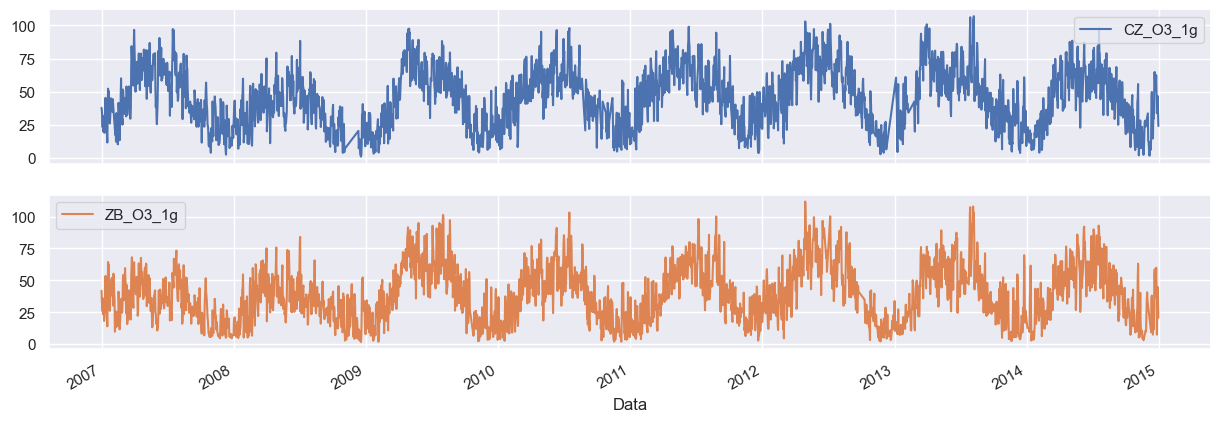

In [276]:
_ = df_sz.plot(kind="line", subplots=True, figsize=(15,5))

Powyższy diagram ma wiele szumów spowodowanych wahaniami pomiarów każdego dnia. W celu pozbycia się tych wahań należy zastosować średnią ruchomą, która pozwala obliczyć średnie wartości dla określonego okna czasowego. Należy to wykonać, ponieważ szumy mogą zniekształcać obraz tendencji długoterminowej.

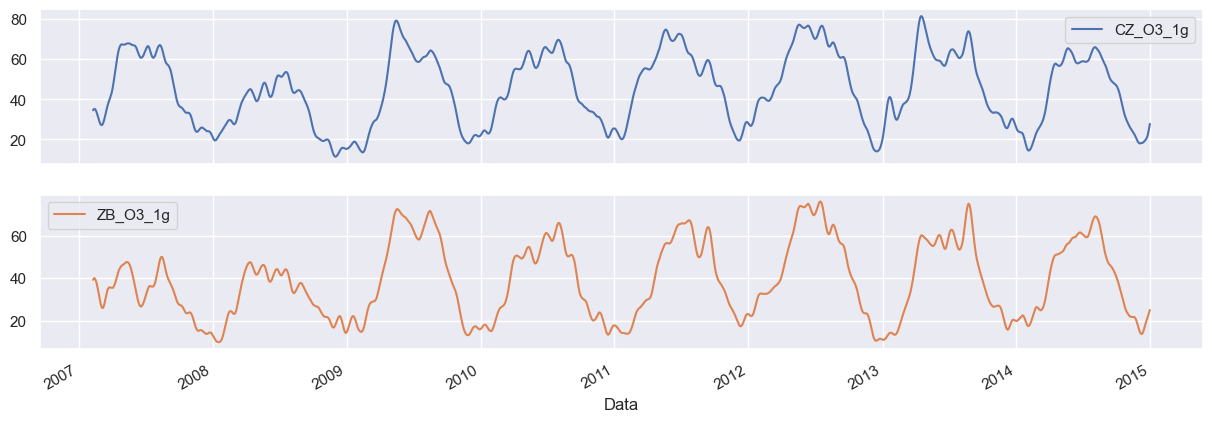

In [279]:
df_sz = df_sz.rolling(14).mean() 
_ = df_sz.plot(kind="line", subplots=True, figsize=(15,5))

Zastosowana średnia ruchoma stworzyła efekt wygładzenia diagramu szergeów czasowych i zredukowała szumy wahań.

<h2> 1. trend szeregu czasowego

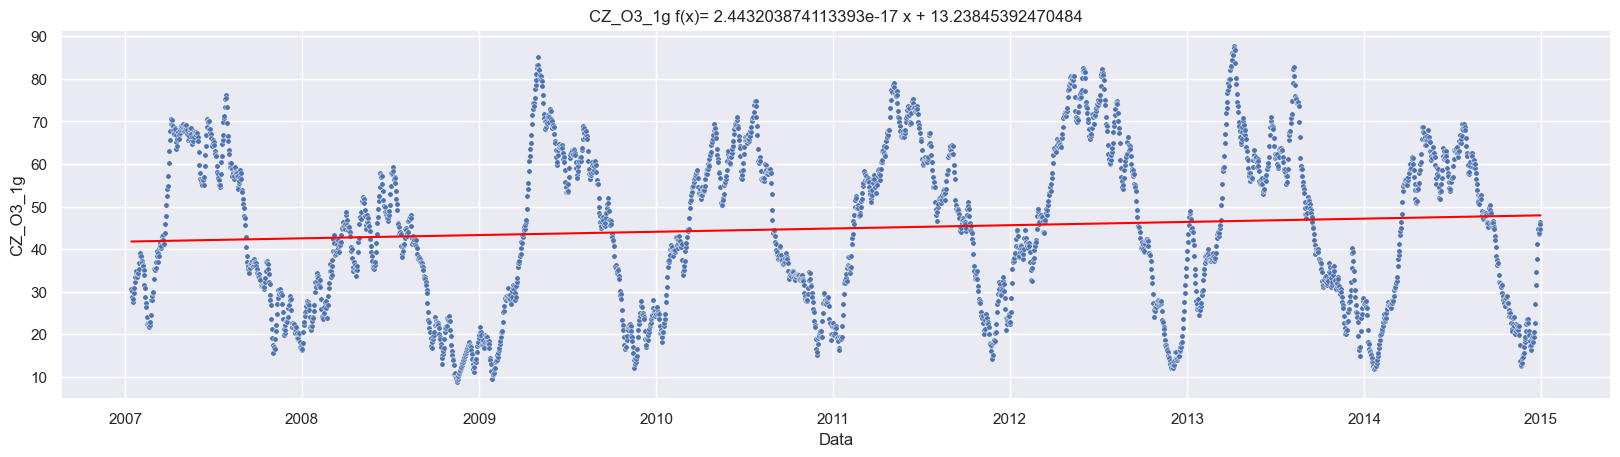

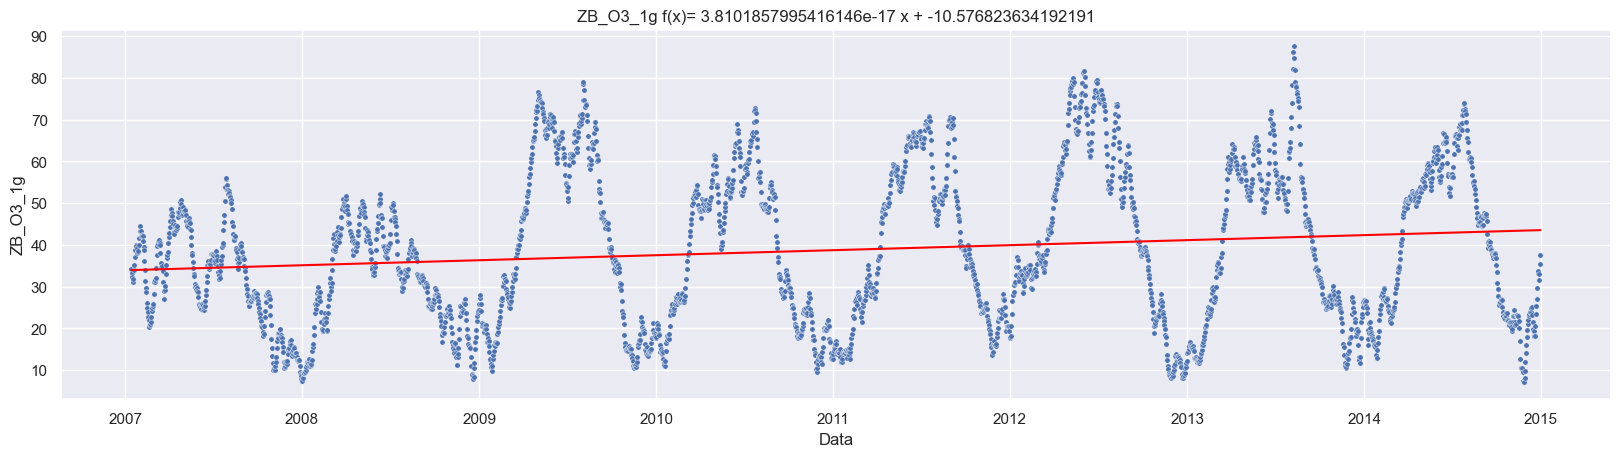

In [266]:
for col in df_sz.columns:
    a, b = np.polyfit(pd.to_numeric(df_sz.index), df_sz[col], deg=1)
    fig = plt.figure().set_figwidth(20)
    plt.title(f"{col} f(x)= {a} x + {b}")
    sns.scatterplot(df_sz[col], s=15)
    sns.lineplot(x=df_sz.index, y=a*pd.to_numeric(df_sz.index)+b, color="red")
    plt.show()

Trend jest na tyle mały, że możemy go pominąć. 

<h2> 2. autokorelacja szeregu

In [267]:
output = {}
for col in df_sz.columns:
    output[col] = (0,0)
    for days in range(300,400):
        autocorrelation = df_sz[col].autocorr(lag=days)
        if output[col][0] < autocorrelation:
            output[col] = (autocorrelation, days)
    print(f"Dla {col} największa korelacja: {output[col][0]} jest w okresie {output[col][1]} dni")

Dla CZ_O3_1g największa korelacja: 0.7686967150776572 jest w okresie 360 dni
Dla ZB_O3_1g największa korelacja: 0.790991760013871 jest w okresie 362 dni


<h2> 3. analiza Fouriera szeregu czasowego - Periodogram

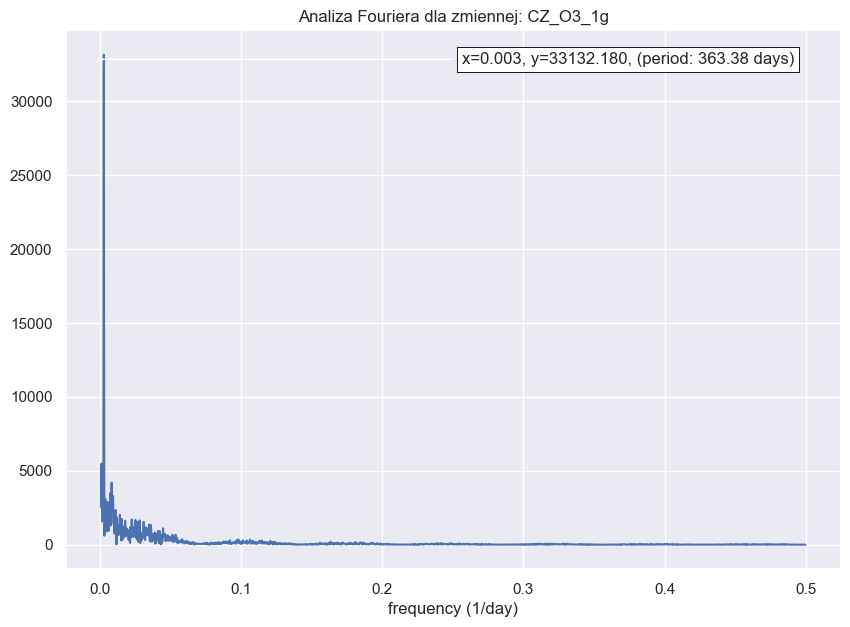

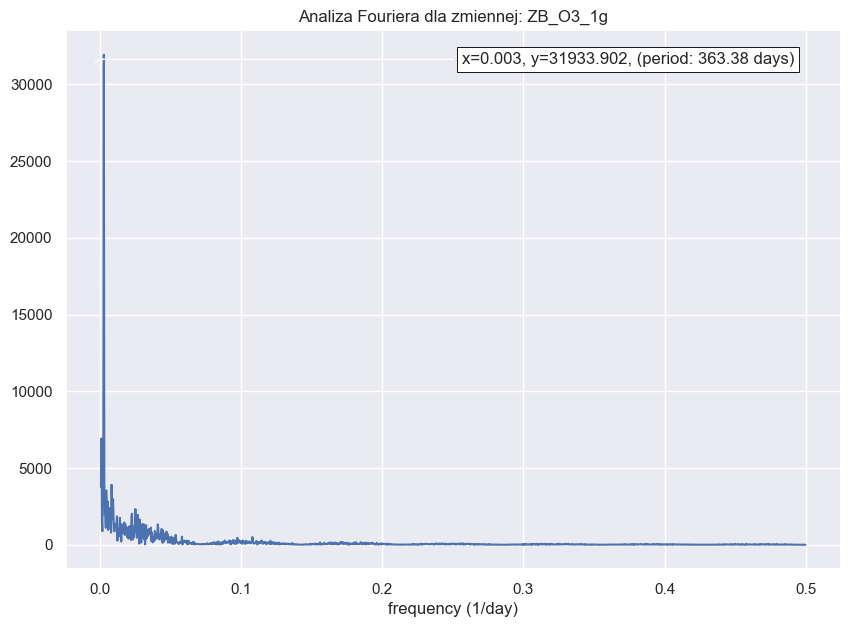

In [268]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
    text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} days)"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)



for col in df_sz.columns:
    nobs = len(df_sz[col])
    temperature_ft = np.abs(np.fft.rfft(df_sz[col]))
    temperature_freq = np.fft.rfftfreq(nobs)
    plt.figure(figsize=(10, 7))
    plt.plot(temperature_freq[2:], temperature_ft[2: ])
    annot_max(temperature_freq[2:], temperature_ft[2: ])
    plt.title(f"Analiza Fouriera dla zmiennej: {col}")

    plt.xlabel('frequency (1/day)')
    plt.show()

#### 4. współczynniki sezonowości 

      seasonal
0   -18.310504
1   -18.681353
2   -19.108858
3   -20.022804
4   -21.030678
..         ...
365 -18.310504
366 -18.681353
367 -19.108858
368 -20.022804
369 -21.030678

[370 rows x 1 columns]


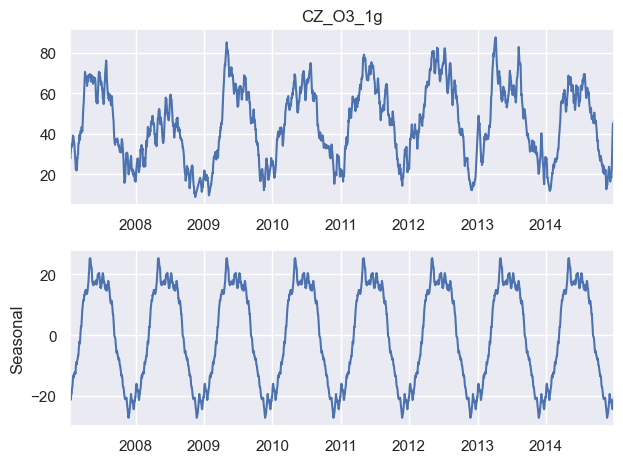

      seasonal
0   -20.241006
1   -20.580257
2   -20.712877
3   -21.830453
4   -22.901499
..         ...
365 -20.241006
366 -20.580257
367 -20.712877
368 -21.830453
369 -22.901499

[370 rows x 1 columns]


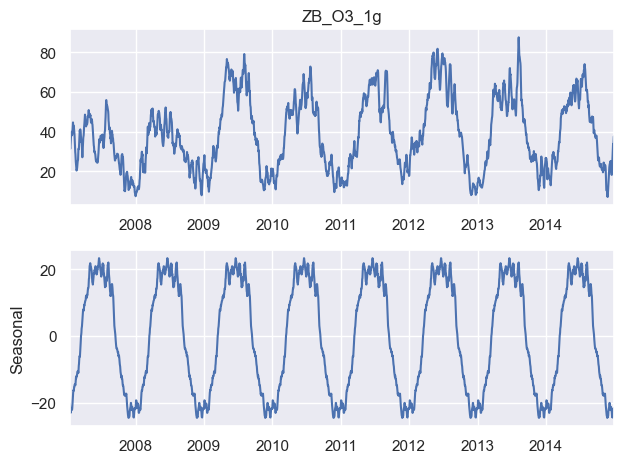

In [269]:
for col in df_sz.columns:
    decompose = seasonal.seasonal_decompose(df_sz[col],model='additive', period=365)
    seasonal_changes = decompose.seasonal.reset_index()
    seasonal_changes = seasonal_changes[seasonal_changes.index < 370]
    seasonal_changes = seasonal_changes.drop("Data", axis=1)
    print(seasonal_changes)
    decompose.plot(resid=False, trend=False)
    plt.show()